# 02.30.10 - RF MFCC20 - Feature importance

## Goals

In this experiment, we use random forest classifiers to assess feature importance for each of the following classification tasks:
- queen/noqueen classification
- hive classification

We expect to get some hints about feature selection.

## Prerequisites

- The dataset exists (if not, execute 02.00.01)
- The dataset features have been populated (if not, execute 02.00.02)


In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information                     
    say_my_name,                     # gets notebook name
    predestination                   # seeds various PRNGs for reproducibiliy
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling


#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to prefix potential outputs

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'  # Name of the feature used for classification
LABEL1 = 'queen'         # Name of the label used for first classification task
LABEL2 = 'hivenum'       # Name of the label used for second classification task
SET_FRAC = 1             # fraction of the the dataset we want to use (allow quick tests if < 1)
TEST_FRAC = 0.1          # fraction of the used dataset we want to put aside in order to assess
                         # non biased performance indicators

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

[2020-09-07/14:28:41.490|14.2%|77.0%|0.28GB] ------------------------------------------------------
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] SAMPLE RATE           : 22050
[2020-09-07/14:28:41.491|00.0%|77.0%|0.28GB] DURATION              : 1.0
[2020-09-07/14:28:41.492|00.0%|77.0%|0.28GB] OVERLAP               : 0.0
[2020-09-07/14:28:41.492|00.0%|77.0%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-07/14:28:41.492|00.0%|77.0%|0.28GB] ------------------------------------------------------


In [2]:
#import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from audace.splitters import serie_to_2D

# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiment,
# shuffle it (and potentially truncate it to speed quick tests)
iprint(">>>>> Query features and labels")
sql = F"select {FEATURE_NAME}, {LABEL1}, iif(hive='Hive1', 0, 1) as {LABEL2} from samples where nobee = 0 and hive in ('Hive1', 'Hive3')"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

# flatten features array
iprint(">>>>> Flatten features")
X = serie_to_2D(df[FEATURE_NAME])


# get labels
y1 = df[LABEL1]
y2 = df[LABEL2]

# Partition dataset into training and test subsets
iprint(">>>>> Partition training/test")
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=TEST_FRAC)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=TEST_FRAC)

# standardize data
iprint(">>>>> Scale")
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

#Create random forest Classifiers, using the experiment parameters
clf1 = RandomForestClassifier(n_estimators=100)
clf2 = RandomForestClassifier(n_estimators=100)

#Train the models using the training sets
iprint('>>>>> Train')
clf1.fit(X1_train, y1_train)
clf2.fit(X2_train, y2_train)

#Predict the response for each test datasets
iprint('>>>>> Predict')
y1_pred = clf1.predict(X1_test)
y2_pred = clf2.predict(X2_test)

# Display information about the classifiers performance
iprint(F"========== SUMMARY {LABEL1} ==========")
iprint(F"Trained over {len(y1_train)} / Tested over {len(y1_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y1_test, y1_pred))
iprint("Precision :",metrics.precision_score(y1_test, y1_pred))
iprint("Recall    :",metrics.recall_score(y1_test, y1_pred))
iprint("F-Measure :",metrics.f1_score(y1_test, y1_pred))

iprint(F"========== SUMMARY {LABEL2} ==========")
iprint(F"Trained over {len(y2_train)} / Tested over {len(y2_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y2_test, y2_pred))
iprint("Precision :",metrics.precision_score(y2_test, y2_pred))
iprint("Recall    :",metrics.recall_score(y2_test, y2_pred))
iprint("F-Measure :",metrics.f1_score(y2_test, y2_pred))


[2020-09-07/14:28:44.518|08.3%|76.9%|0.28GB] >>>>> Query features and labels
[2020-09-07/14:28:46.908|08.3%|78.4%|0.33GB] >>>>> Flatten features
[2020-09-07/14:28:46.948|18.8%|79.0%|0.37GB] >>>>> Partition training/test
[2020-09-07/14:28:46.993|25.0%|79.9%|0.45GB] >>>>> Scale
[2020-09-07/14:28:47.452|22.6%|79.2%|0.45GB] >>>>> Train
[2020-09-07/14:29:40.143|16.6%|79.1%|0.45GB] >>>>> Predict
[2020-09-07/14:29:40.208|08.8%|79.1%|0.45GB] ========== SUMMARY queen ==========
[2020-09-07/14:29:40.208|00.0%|79.1%|0.45GB] Trained over 10220 / Tested over 1136
[2020-09-07/14:29:40.209|00.0%|79.1%|0.45GB] Accuracy  : 0.9753521126760564
[2020-09-07/14:29:40.211|00.0%|79.1%|0.45GB] Precision : 0.9902597402597403
[2020-09-07/14:29:40.213|00.0%|79.1%|0.45GB] Recall    : 0.9242424242424242
[2020-09-07/14:29:40.214|00.0%|79.1%|0.45GB] F-Measure : 0.9561128526645767
[2020-09-07/14:29:40.215|33.3%|79.1%|0.45GB] ========== SUMMARY hivenum ==========
[2020-09-07/14:29:40.215|00.0%|79.1%|0.45GB] Trained ove

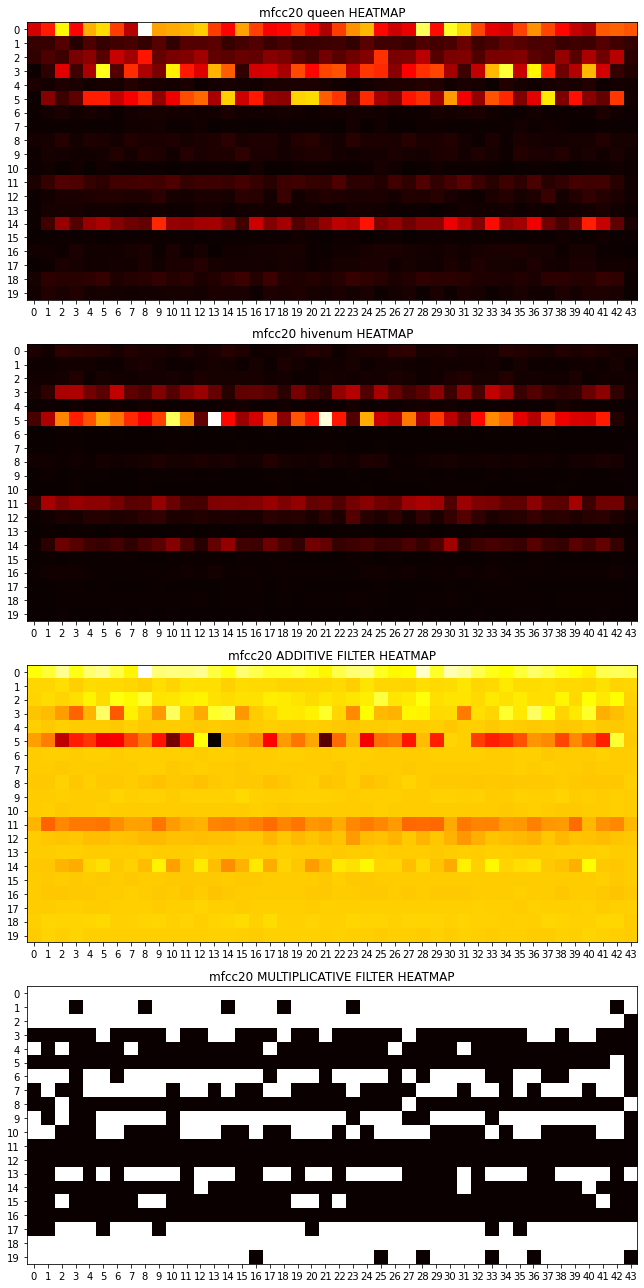

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_feature(img):
    plt.imshow(img, cmap = mpl.cm.hot, interpolation="nearest")
    plt.yticks(np.arange(0, img.shape[0], 1))
    plt.xticks(np.arange(0, img.shape[1], 1))

feature_shape = df[FEATURE_NAME][0].shape
fi1 = clf1.feature_importances_  
#fi1 = fi1.reshape(1,feature_shape[0])
fi1 = fi1.reshape(feature_shape)

fi2 = clf2.feature_importances_  
#fi2 = fi2.reshape(1,feature_shape[0])
fi2 = fi2.reshape(feature_shape)


plt.figure(figsize=(24, 18))


plt.subplot(411)
plt.title(FEATURE_NAME + " " + LABEL1 + " HEATMAP")
plot_feature(fi1)  

plt.subplot(412)
plt.title(FEATURE_NAME + " " + LABEL2 + " HEATMAP")
plot_feature(fi2)  

plt.subplot(413)
plt.title(FEATURE_NAME + " " + "ADDITIVE FILTER HEATMAP")
fi = fi1-fi2
plot_feature(fi)  


plt.subplot(414)
plt.title(FEATURE_NAME + " " + "MULTIPLICATIVE FILTER HEATMAP")
fi = (fi1/fi2 > 2)
plot_feature(fi)  



plt.tight_layout()


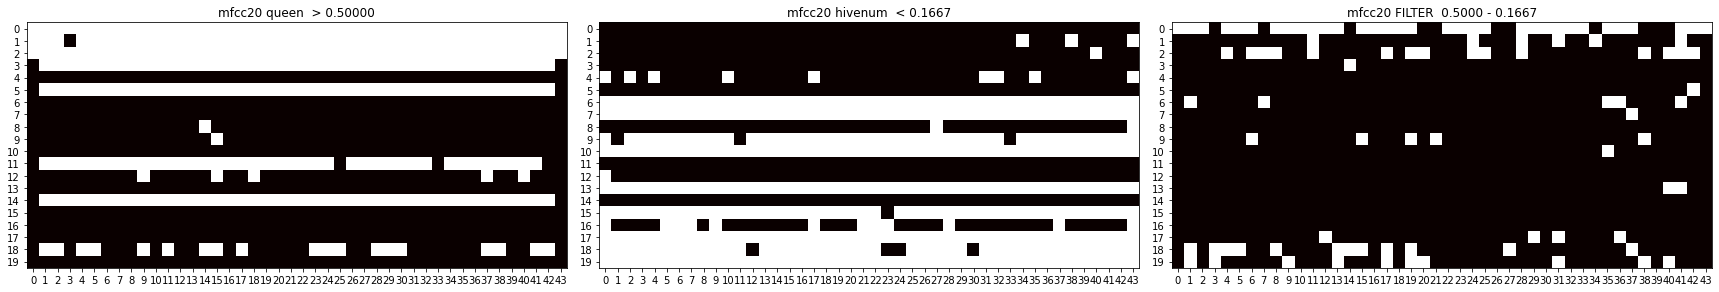

In [6]:
ratio = feature_shape[0] * feature_shape[1]

t1 = 0.5
t2 = t1/3

plt.figure(figsize=(24, 12))

plt.subplot(131)
plt.title(F"{FEATURE_NAME} {LABEL1}  > {t1:0.5f}")
fi = (fi1*ratio > t1)
plot_feature(fi)  

plt.subplot(132)
plt.title(F"{FEATURE_NAME} {LABEL2}  < {t2:0.4f}")
fi = (fi2*ratio < t2)
plot_feature(fi)   

plt.subplot(133)
plt.title(F"{FEATURE_NAME} FILTER  {t1:0.4f} - {t2:0.4f}")
fi = (fi1/fi2 > 5)
plot_feature(fi)          

plt.tight_layout()